## Performance of `torch.index_copy_`

In [5]:
import os
os.environ['LIBTPU_INIT_ARGS']='--xla_tpu_scoped_vmem_limit_kib=98304 --xla_tpu_use_minor_sharding_for_major_trivial_input=true --xla_tpu_relayout_group_size_threshold_for_reduce_scatter=1 --xla_tpu_assign_all_reduce_scatter_layout=true --xla_tpu_enable_data_parallel_all_reduce_opt=true --xla_tpu_data_parallel_opt_different_sized_ops=true --xla_tpu_enable_async_collective_fusion=true --xla_tpu_enable_async_collective_fusion_fuse_all_gather=true --xla_tpu_enable_async_collective_fusion_multiple_steps=true  --xla_tpu_overlap_compute_collective_tc=true  --xla_enable_async_all_gather=true --xla_tpu_enable_async_collective_fusion_fuse_all_reduce=false  --xla_tpu_enable_sparse_core_collective_offload_all_reduce=true --xla_tpu_use_tc_device_shape_on_sc=true  --xla_sc_disable_megacore_partitioning=true  --2a886c8_chip_config_name=megachip_tccontrol'

import torch_xla
import jax

print(torch_xla.devices())

[device(type='xla', index=0), device(type='xla', index=1), device(type='xla', index=2), device(type='xla', index=3), device(type='xla', index=4), device(type='xla', index=5), device(type='xla', index=6), device(type='xla', index=7)]


`torch.index_copy_` is used in vLLM pallas attention layers to copy the key and
value vectors generated during the forward pass of one scheduling step into the
KV cache.

```py
def write_to_kv_cache(
    key: torch.Tensor,
    value: torch.Tensor,
    kv_cache: torch.Tensor,
    slot_mapping: torch.Tensor,
) -> None:
    """Write the key and values to the KV cache.

    Args:
        key: shape = [num_tokens, num_kv_heads * head_size]
        value: shape = [num_tokens, num_kv_heads *  head_size]
        kv_cache = [num_blocks, block_size, num_kv_heads * 2, head_size]
        slot_mapping = [num_tokens]

    """
    _, _, num_combined_kv_heads, head_size = kv_cache.shape
    head_size = cdiv(head_size,
                     TPU_HEAD_SIZE_ALIGNMENT) * TPU_HEAD_SIZE_ALIGNMENT
    kv = torch.cat([key, value], axis=-1).reshape(-1, num_combined_kv_heads,
                                                  head_size)

    torch.ops.xla.dynamo_set_buffer_donor_(kv_cache, True)

    kv_cache = kv_cache.flatten(0, 1)
    kv_cache.index_copy_(0, slot_mapping, kv)
```

`slot_mapping` might look like:

```py
torch.Size([16]) tensor([64, 65, 66, 67, 68, 69, 70, 71, 72, 1000000000, 1000000000, ...])
```

which indicates a light prefill step involving 9 valid tokens, or

```py
torch.Size([256]) tensor([73, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
                          192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
                          256, 257, 258, 259, 260, 261, 262, 263, 264, 265, ...])
```

which indicates a heavy mixed prefill and decode step processing 256 tokens, or

```py
torch.Size([16]) tensor([74, 141, 204, 485, 1000000000, 1000000000, ...])
```

which indicates a light decode step generating 4 new tokens for 4 requests, etc.

`1000000000` is an out-of-bounds sentinel value that indicates that particular
token slot is unused.

In `google/gemma-3-27b-it` over 8 chips via tensor parallelism, the KV cache has
a shape of `bf16[5607,64,4,128]` (flattened to `bf16[358848,4,128]`). Gemma 3 has
16+16=32 KV heads but that's sharded over 8 chips, so each chip stores 4 heads.

In vLLM TPU, each scheduling step appears to process 16 to 256 tokens. We will
now benchmark the HBM throughput of a scattered copy of 256 tokens on a v6e chip.

In [6]:
import numpy as np
import torch
import torch_xla.core.xla_model as xm
import torch_xla.debug.profiler as xp
from xprof_step_time.step_duration import step_duration_from_latest_profile

def index_copy(kv_cache, new_kv, slot_mapping):
  assert new_kv.shape[0] == slot_mapping.shape[0]
  assert new_kv.shape[1:] == kv_cache.shape[2:]
  torch.ops.xla.dynamo_set_buffer_donor_(kv_cache, True)
  kv_cache.flatten(0, 1).index_copy_(0, slot_mapping, new_kv)

@torch.compile(backend='openxla')
def benchmark_step(kv_cache, new_kv, slot_mapping):
  index_copy(kv_cache, new_kv, slot_mapping)

def benchmark_index_copy(num_heads=4):
  # Create a slot mapping of size 256.
  slot_mapping = torch.from_numpy(np.arange(256, dtype=np.uint32)).long().to('xla')

  # Create a KV cache with 5607 blocks, each with 64 token slots.
  BLOCK_SIZE = 64
  HEAD_SIZE = 128
  kv_cache = torch.rand((5607, BLOCK_SIZE, num_heads, HEAD_SIZE), dtype=torch.bfloat16).to('xla')

  # Benchmark index_copy performance.
  new_kv = torch.rand((256, num_heads, HEAD_SIZE), dtype=torch.bfloat16).to('xla')

  # Warm up
  def run_warmup():
    for i in range(2):
      benchmark_step(kv_cache, new_kv, slot_mapping)
      torch_xla.sync(wait=True)
      xm.wait_device_ops()

  run_warmup()

  # Benchmark
  PROFILE_DIR = 'profile/index_copy'
  os.makedirs(PROFILE_DIR, exist_ok=True)

  def run_benchmark():
    torch_xla.sync(wait=True)
    xm.wait_device_ops()
    NUM_STEPS = 1000
    xp.start_trace(PROFILE_DIR)
    for i in range(NUM_STEPS):
      benchmark_step(kv_cache, new_kv, slot_mapping)
    torch_xla.sync(wait=True)
    xm.wait_device_ops()
    xp.stop_trace()
    step_time = step_duration_from_latest_profile(PROFILE_DIR, ignore_gaps=True, verbose=False)
    bytes_copied = new_kv.numel() * new_kv.element_size()
    print(f"Execution took {step_time * 1000:.4f} ms. Bytes copied: {bytes_copied} bytes.")
    throughput = bytes_copied / step_time
    print(f"Throughput: {throughput / 1e9:.2f} GB/s.")
    return throughput

  return run_benchmark()

throughput_4 = benchmark_index_copy(num_heads=4)

Execution took 0.0234 ms. Bytes copied: 262144 bytes.
Throughput: 11.19 GB/s.


Let's try hypothetical scenarios with more KV heads.

In [10]:
throughputs = [throughput_4]
num_heads = [4]
for num_head in [8, 16, 32, 64]:
  print(f"Benchmarking with {num_head} heads...")
  throughput = benchmark_index_copy(num_heads=num_head)
  throughputs.append(throughput)
  num_heads.append(num_head)

num_heads = np.array(num_heads)
throughputs = np.array(throughputs) / 1e9  # Convert to GB/s

Benchmarking with 8 heads...


Execution took 0.0235 ms. Bytes copied: 524288 bytes.
Throughput: 22.30 GB/s.
Benchmarking with 16 heads...
Execution took 0.0266 ms. Bytes copied: 1048576 bytes.
Throughput: 39.49 GB/s.
Benchmarking with 32 heads...
Execution took 0.0285 ms. Bytes copied: 2097152 bytes.
Throughput: 73.51 GB/s.
Benchmarking with 64 heads...
Execution took 0.0321 ms. Bytes copied: 4194304 bytes.
Throughput: 130.56 GB/s.


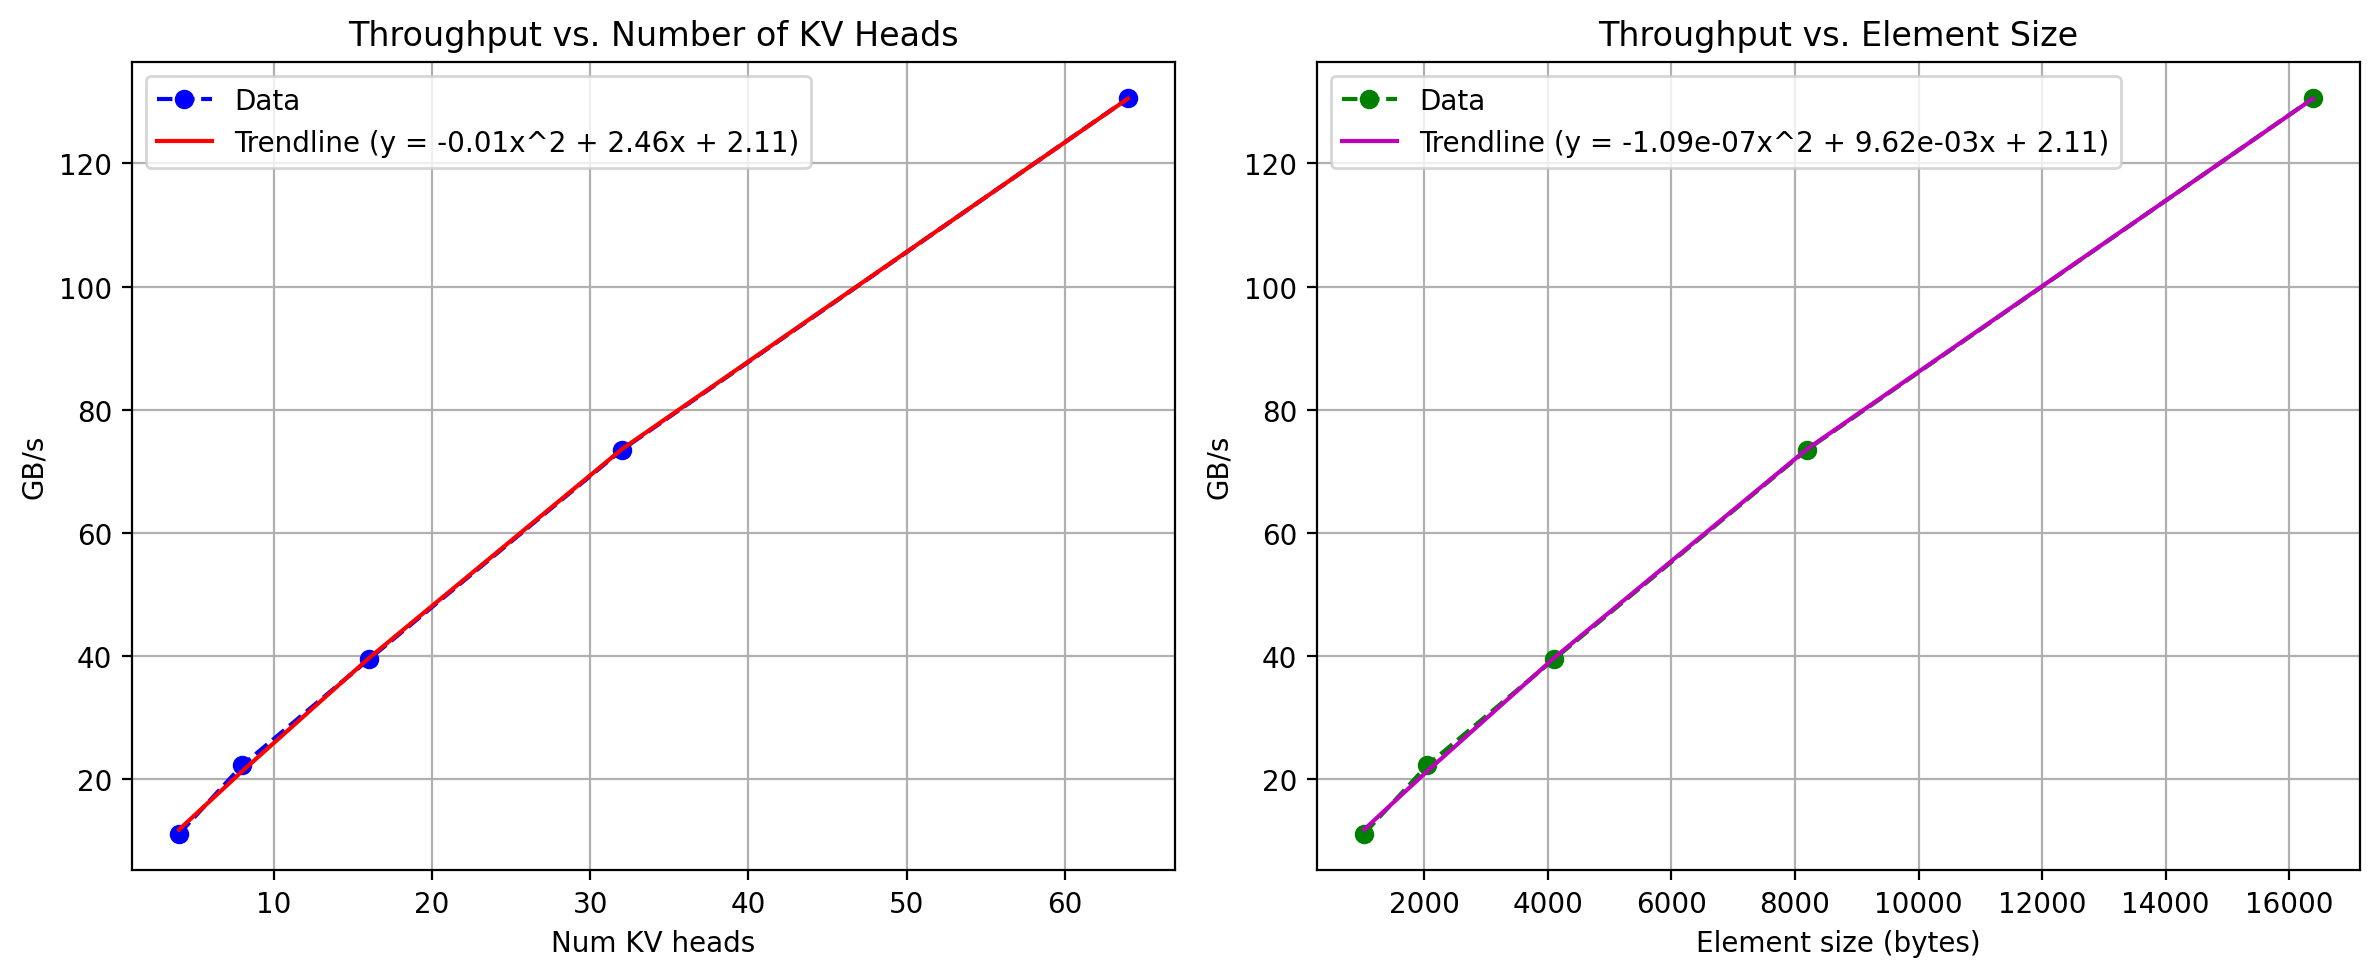

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- First subplot: Throughput vs. Number of KV Heads ---
coeffs1 = np.polyfit(num_heads, throughputs, 2)
fitted1 = np.poly1d(coeffs1)
ax1.plot(num_heads, throughputs, 'bo--', label='Data')
ax1.plot(num_heads, fitted1(num_heads), 'r-', label=f'Trendline (y = {coeffs1[0]:.2f}x^2 + {coeffs1[1]:.2f}x + {coeffs1[2]:.2f})')
ax1.set_title('Throughput vs. Number of KV Heads')
ax1.set_ylabel('GB/s')
ax1.set_xlabel('Num KV heads')
ax1.legend()
ax1.grid(True)

# --- Second subplot: Throughput vs. Element Size ---
element_size = num_heads * 128 * 2  # in bytes

coeffs2 = np.polyfit(element_size, throughputs, 2)
fitted2 = np.poly1d(coeffs2)
ax2.plot(element_size, throughputs, 'go--', label='Data')
# Using scientific notation for coefficients as they can be very small
ax2.plot(element_size, fitted2(element_size), 'm-', label=f'Trendline (y = {coeffs2[0]:.2e}x^2 + {coeffs2[1]:.2e}x + {coeffs2[2]:.2f})')
ax2.set_title('Throughput vs. Element Size')
ax2.set_ylabel('GB/s')
ax2.set_xlabel('Element size (bytes)')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent titles/labels from overlapping and show the plot
plt.tight_layout()
plt.show()

## Observations

The `index_copy_` operation is lowered to an XLA `scatter` operation.

![index copy hlo](./index-copy-hlo.png)

We're not sure how `scatter` is implemented. However, it's clear that throughput
suffers when each element to be scattered is small. When copying `bf16[4, 128]`
elements, the throughput is only 11 GB/s. Throughput more or less scales linearly
with element size, modulo a small `-0.01x^2` overhead factor. For every KB of
scatter element size increase, throughput increases by 9.6 GB.